In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

import scipy.ndimage as scn
import astropy.stats as aps
import astropy.io.fits as pf
from astropy.time import Time

from skyfield.units import Angle
from skyfield.api import load, wgs84, EarthSatellite 

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

rootdir = '/Users/peter/Projects/mascara/starlink_data/'
testdir = rootdir + 'test_data/'
savedir = rootdir + 'images/thesis/'
datadir = rootdir + 'full_data/'

# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams['font.size'] = 20  

# %matplotlib qt
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
def get_data(category):
    
    if category=='passages':
        files = sorted(glob.glob(f'{datadir}passages_*.p'))
        
    if category=='passed':
        files = sorted(glob.glob(f'{datadir}passed_*.p'))
    
    if category=='vmags':
        files = sorted(glob.glob(f'{datadir}vmags_july/vmags_*.p'))
        
    if category=='pools':
        files = sorted(glob.glob(f'{datadir}pool_*.p'))
        
    return files


# =================================================================================


def reduce_passages(camid):
    
    all_passages = pd.read_pickle(f'{datadir}passages_20221023{camid}.p')
    pool = pd.read_pickle(f'{datadir}pool_{camid}.p')

    passages = {}
    for lstseq, data in all_passages.items():
        if lstseq in pool:
            passages[lstseq] = {}
            for satnum in pool[lstseq]:
                if satnum in data:
                    passages[lstseq][satnum] = data[satnum]
                    
    return passages


# =================================================================================


def get_starlink_tles():
    
    # Load TLEs for all satellite passages
    satfiles = f"{testdir}3leComplete.txt"
    with open(satfiles) as f:
        all_tles = f.readlines()
        f.close()

    # Split TLE list into individual lists for each TLE
    all_tles = [i.strip() for i in all_tles]
    tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

    # Reduce TLEs to Starlink only
    starlink_tles = []
    for tle in tles:
        if "STARLINK" in tle[0]:
            starlink_tles.append(tle)
            
    for tle in starlink_tles:
        tle[0] = tle[0][2:]
        
    return starlink_tles


# =================================================================================


def get_starlink_launches():
    """
    For the scraping: probably not the best way, but essentially just adds everything to a list.
    Thinking have it this way such that it just needs to be run once.
    
    """
    
    import requests
    from bs4 import BeautifulSoup
    
    base_url = 'https://nssdc.gsfc.nasa.gov/nmc/spacecraft/query'
    search_params = {'name': 'starlink'}

    # Send a GET request to the website
    response = requests.get(base_url, params=search_params)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    
    # Index 0: Name         ...  Starlink 1007
    # Index 1: NSSDCA ID    ...  2019-074A
    # Index 2: Launch date  ...  2019-11-11 (Y:M:D)
    
    i=0
    names = []
    dates = []

    # Find the table rows that contain satellite data
    for row in soup.find_all('td'):
        entry = row.get_text()
        i+=1
        if i==1:
            entry = entry.upper().replace(' ', '-') #since my data is uppercase and hyphenated
            names.append(entry)
        if i==2:
            continue
        if i==3:
            dates.append(entry)
            i=0
            
    df = pd.DataFrame({'name': names, 'launch': dates})
    df['launch'] = pd.to_datetime(df['launch'])
    

    starlink_tles = get_starlink_tles()
        
        
    # DarkSat = Starlink-1130 = 44932U
    # Visors - 7 August 2020
    # Visors removed - 14 September 2021 onwards
    # V1.5 - 30 June 2021 onwards
    # V2-mini: 27 February 2023, 19 April 2023, 19 May 2023 ---> out of our date range
    
    
    df2 = pd.DataFrame(columns=['starlink', 'satnum', 'launch', 'version', 'type'])
    for i, tle in enumerate(starlink_tles):
        starlink = tle[0]
        try:
            idx = np.where(df.name.values == starlink)[0][0]
        except:
            continue
        satnum = tle[1].split()[1]
        date = df.launch.iloc[idx]
        satname = df.name.iloc[idx]

        # v0.1
        if date < pd.to_datetime('2018-02-23'):
            version = '0.1'
            sattype = 'tintin'

        # v0.9
        if date > pd.to_datetime('2018-02-23') and date < pd.to_datetime('2019-11-12'):
            version = '0.9'
            sattype = 'standard'

        # v1.0
        if date > pd.to_datetime('2019-11-12') and date < pd.to_datetime('2021-05-27'):
            version = '1.0'
            if satnum == '44932U':
                sattype = 'darksat'
            elif date > pd.to_datetime('2020-06-30'):
                sattype = 'visorsat'
            else:
                sattype = 'standard'

        # v1.5
        if date > pd.to_datetime('2021-05-27'):
            version = '1.5'
            if date < pd.to_datetime('2021-09-13'):
                sattype = 'visorsat'
            else:
                sattype = 'standard'


        row_data = [satname, satnum, date, version, sattype]
        df2.loc[len(df2)] = row_data
    
    return df2


# =================================================================================


def observation_info():
    
    df = get_starlink_launches()
    passages = get_data(category='passages')
    
    ### Timerange of observations
    for psg in passages:
        p = pd.read_pickle(psg)
        camid = psg[-5:-2]

        # JD of first observation
        lstseq0 = list(p)[0]
        sat0 = list(p[lstseq0])[0]
        jd0 = p[lstseq0][sat0]['start']['jd']

        # JD of last observation
        lstseq1 = list(p)[-1]
        sat1 = list(p[lstseq1])[0]
        jd1 = p[lstseq1][sat1]['end']['jd']

        t0 = Time(jd0, format='jd', scale='utc')
        t1 = Time(jd1, format='jd', scale='utc')
        time_diff = t1 - t0
        print(f"{camid} - time range spanned: {time_diff.to('hour')} ... {t0.iso} to {t1.iso}")
    
    
    ### Unique Starlinks
    
    vmags = get_data(category='vmags')
    all_sats = []
    for vmag in vmags:
        
        camid = vmag[-5:-2]
        v = pd.read_pickle(vmag)
        sats = []
        for lstseq in v:
            sats.extend(list(v[lstseq])[2:])
            
        all_sats.extend(sats)
        unique_sats = list(set(sats)) 
        print(f'{camid}: {len(sats)} observations;  {len(unique_sats)} unique starlinks')
        
    all_unique_sats = list(set(all_sats))
    print(f'\n{len(all_sats)} total observations  -  {len(all_unique_sats)} unique Starlinks\n')
    
    
    ### Type of Starlinks
    
    version = []
    sat_types = []
    for satnum in all_sats:
        sat_types.append(df.loc[df['satnum'] == satnum].type.values[0])
        version.append(df.loc[df['satnum'] == satnum].version.values[0])
    

    version_unique = []    
    sat_types_unique = []
    for satnum in all_unique_sats:
        sat_types_unique.append(df.loc[df['satnum'] == satnum].type.values[0])
        version_unique.append(df.loc[df['satnum'] == satnum].version.values[0])
        
    print(f"Standard:   {sat_types.count('standard')}  -   {sat_types_unique.count('standard')}")
    print(f"VisorSat:   {sat_types.count('visorsat')}   -   {sat_types_unique.count('visorsat')}")
    print(f"DarkSats:   {sat_types.count('darksat')}     -   {sat_types_unique.count('darksat')}\n")
    
    # Total
    count = {}
    x = list(zip(sat_types, version))
    print('For all observations:\n')
    for elem in x:
        key = elem[0] 
        val = elem[1]   
        if key in count:
            inner = count[key]
        else:
            inner= {}
            count[key] = inner  
        if val in inner:
            inner[val] += 1
        else:
            inner[val] = 1
            
    for key, inner in count.items():
        print(key + ":")
        for val, count in inner.items():
            print(f"  {val}: {count}")
            
    print('\n')
    
    # Unique
    count = {}
    x = list(zip(sat_types_unique, version_unique))
    print('For unique observations:\n')
    for elem in x:
        key = elem[0] 
        val = elem[1]   
        if key in count:
            inner = count[key]
        else:
            inner= {}
            count[key] = inner  
        if val in inner:
            inner[val] += 1
        else:
            inner[val] = 1
            
    for key, inner in count.items():
        print(key + ":")
        for val, count in inner.items():
            print(f"  {val}: {count}")
    

# =================================================================================
    

def get_siteinfo():
    confdir = '/Users/Peter/Projects/mascara/fotos-python3/bringfiles/siteinfo.dat'
    dtype = [('sitename', '|U20'), ('lat', 'float32'), ('lon', 'float32'), ('height', 'float32'), ('ID', '|U2')]
    siteinfo = np.genfromtxt(confdir, dtype=dtype)   
    mask = siteinfo['ID'] == 'LS'
    siteinfo = siteinfo[mask]
    return siteinfo


# =================================================================================


def create_dataframe():
    
    # ALL IMPORTANT INFO IN ONE DATAFRAME!!!
    
    d = {}
    vmag_files = get_data(category='vmags')
    satinfo = get_starlink_launches()
    
    for file in vmag_files:
        camid = file[-5:-2]
        vmags = pd.read_pickle(file)
        
        all_sats = []
        for lstseq in vmags:
            all_sats.extend(list(vmags[lstseq])[2:])
        sats = list(set(all_sats)) 

        # Creating a dictionary where each key is a unique satellite
        satdict = {}
        for satnum in sats:
            satdict[satnum] = {
                'satname':[], 'vmag':[], 'delta':[], 'flux':[], 'jd0':[], 'jd1':[], 
                'camid':[], 'type':[], 'version':[], 'annulus':[], 'launch':[]
            }
        
        for lstseq in vmags:
            satnums = list(vmags[lstseq])[2:]
            for satnum in satnums:
                if satnum in satdict.keys():
                    
                    jd0 = vmags[lstseq]['JD0']
                    jd1 = vmags[lstseq]['JD1']
                    vmag = vmags[lstseq][satnum]['vmag']
                    satname = vmags[lstseq][satnum]['name']
                    
                    flux = vmags[lstseq][satnum]['flux']
                    delta = vmags[lstseq][satnum]['delta']
                    area = vmags[lstseq][satnum]['annulus']
                    
                    launch = satinfo.loc[satinfo['satnum'] == satnum].launch.values[0]
                    sattype = satinfo.loc[satinfo['satnum'] == satnum].type.values[0]
                    version = satinfo.loc[satinfo['satnum'] == satnum].version.values[0]

                    satdict[satnum]['jd0'].append(jd0)
                    satdict[satnum]['jd1'].append(jd1)                                        
                    satdict[satnum]['vmag'].append(vmag)
                    satdict[satnum]['flux'].append(flux)
                    satdict[satnum]['delta'].append(delta)
                    satdict[satnum]['camid'].append(camid)
                    satdict[satnum]['type'].append(sattype)
                    satdict[satnum]['annulus'].append(area)
                    satdict[satnum]['launch'].append(launch)
                    satdict[satnum]['version'].append(version)
                    satdict[satnum]['satname'].append(satname)
                    
            
        d[camid] = pd.DataFrame([
            (satnum, satname, vmag, delta, flux, jd0, jd1, camid, sattype, version, area, launch) \
            for satnum, vals in satdict.items() \
            for satname, vmag, delta, flux, jd0, jd1, camid, sattype, version, area, launch in zip(
                vals['satname'], vals['vmag'], vals['delta'], vals['flux'], vals['jd0'], vals['jd1'], 
                vals['camid'], vals['type'], vals['version'], vals['annulus'], vals['launch']
            )], columns=['satnum', 'satname', 'vmag', 'delta', 'flux', 'JD0', 'JD1', 'camid', 
                         'type', 'version', 'annulus', 'launch']
        )
    
    df = pd.concat(d.values(), ignore_index=True)
    
    # ------
    
    starlink_tles = get_starlink_tles() 
    eph = load('de421.bsp')
    sun = eph['sun']
    earth = eph['earth']
    
    ts = load.timescale()
    site = get_siteinfo()
    mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
    observer = mascara + earth
    
    sorted_df = df.sort_values('JD0')
    for index, row in sorted_df.iterrows():
        t = row['JD0']
        obs_time = ts.ut1_jd(t)
        
        # Sun position
        astro = observer.at(obs_time).observe(sun)
        app = astro.apparent()
        alt, az, dist = app.altaz()
        df.loc[index, 'sun_alt'] = alt.degrees
        df.loc[index, 'sun_az'] = az.degrees
        
        satname = row.satname
        for tle in starlink_tles:
            if satname in tle[0]:
                sat = EarthSatellite(tle[1], tle[2], tle[0], ts) 
                
                # Inclination
                inc = sat.model.inclo
                inc = Angle(radians=inc).degrees
                df.loc[index, 'inc'] = inc
                
                # Position - altaz
                diff = sat - mascara
                topocentric = diff.at(obs_time)
                alt, az, dist = topocentric.altaz()
                df.loc[index, 'alt'] = alt.degrees
                df.loc[index, 'az'] = az.degrees
                df.loc[index, 'range'] = dist.km
                
                # Position - radec
                ra, dec, _ = topocentric.radec() 
                df.loc[index, 'ra'] = ra.hours
                df.loc[index, 'dec'] = dec.degrees
                
                # Height
                geocentric = sat.at(obs_time)
                height = wgs84.height_of(geocentric)
                df.loc[index, 'height'] = height.km
                
                # Phase angle            
                sat_pov = earth + sat
                phase_angle = sat_pov.at(obs_time).observe(observer).phase_angle(sun)
                df.loc[index, 'phase_angle'] = phase_angle.degrees
                
                """
                phase_angle(): given an illuminator (usually the Sun) as their argument, compute 
                the angle Sun-target-observer. Returns the Angle from the body’s point of view between 
                light arriving from the Sun and the light departing toward the observer. This angle is 0° 
                if the observer is in the same direction as the Sun and sees the body as fully illuminated, 
                and 180° if the observer is behind the body and sees only its dark side
                """

                break   
            
                
    # Normalize the magnitudes to a fixed range of 550 km
    # THIS IS NOT A LINEAR ADJUSTMENT!
    # The factor for adjusting the apparent magnitudes from the actual range to a standard distance 
    # determined based on the inverse square law of light!
    
    # Note, this is also how the Zwicky paper does it! m_550 = m - 5*log10(r/550)
    
    #df['delta_norm'] = np.sqrt(df['delta']**2 + (2.5 * np.log10(factor) * np.log(10) * df['delta'])**2)
    
    
    df['vmag_norm_550'] = df['vmag'] - 5 * np.log10(df['range']/550.)
    df['vmag_norm_1000'] = df['vmag'] - 5 * np.log10(df['range']/1000.)

    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df


# =================================================================================


In [3]:
df = create_dataframe()
df_starlink = get_starlink_launches()

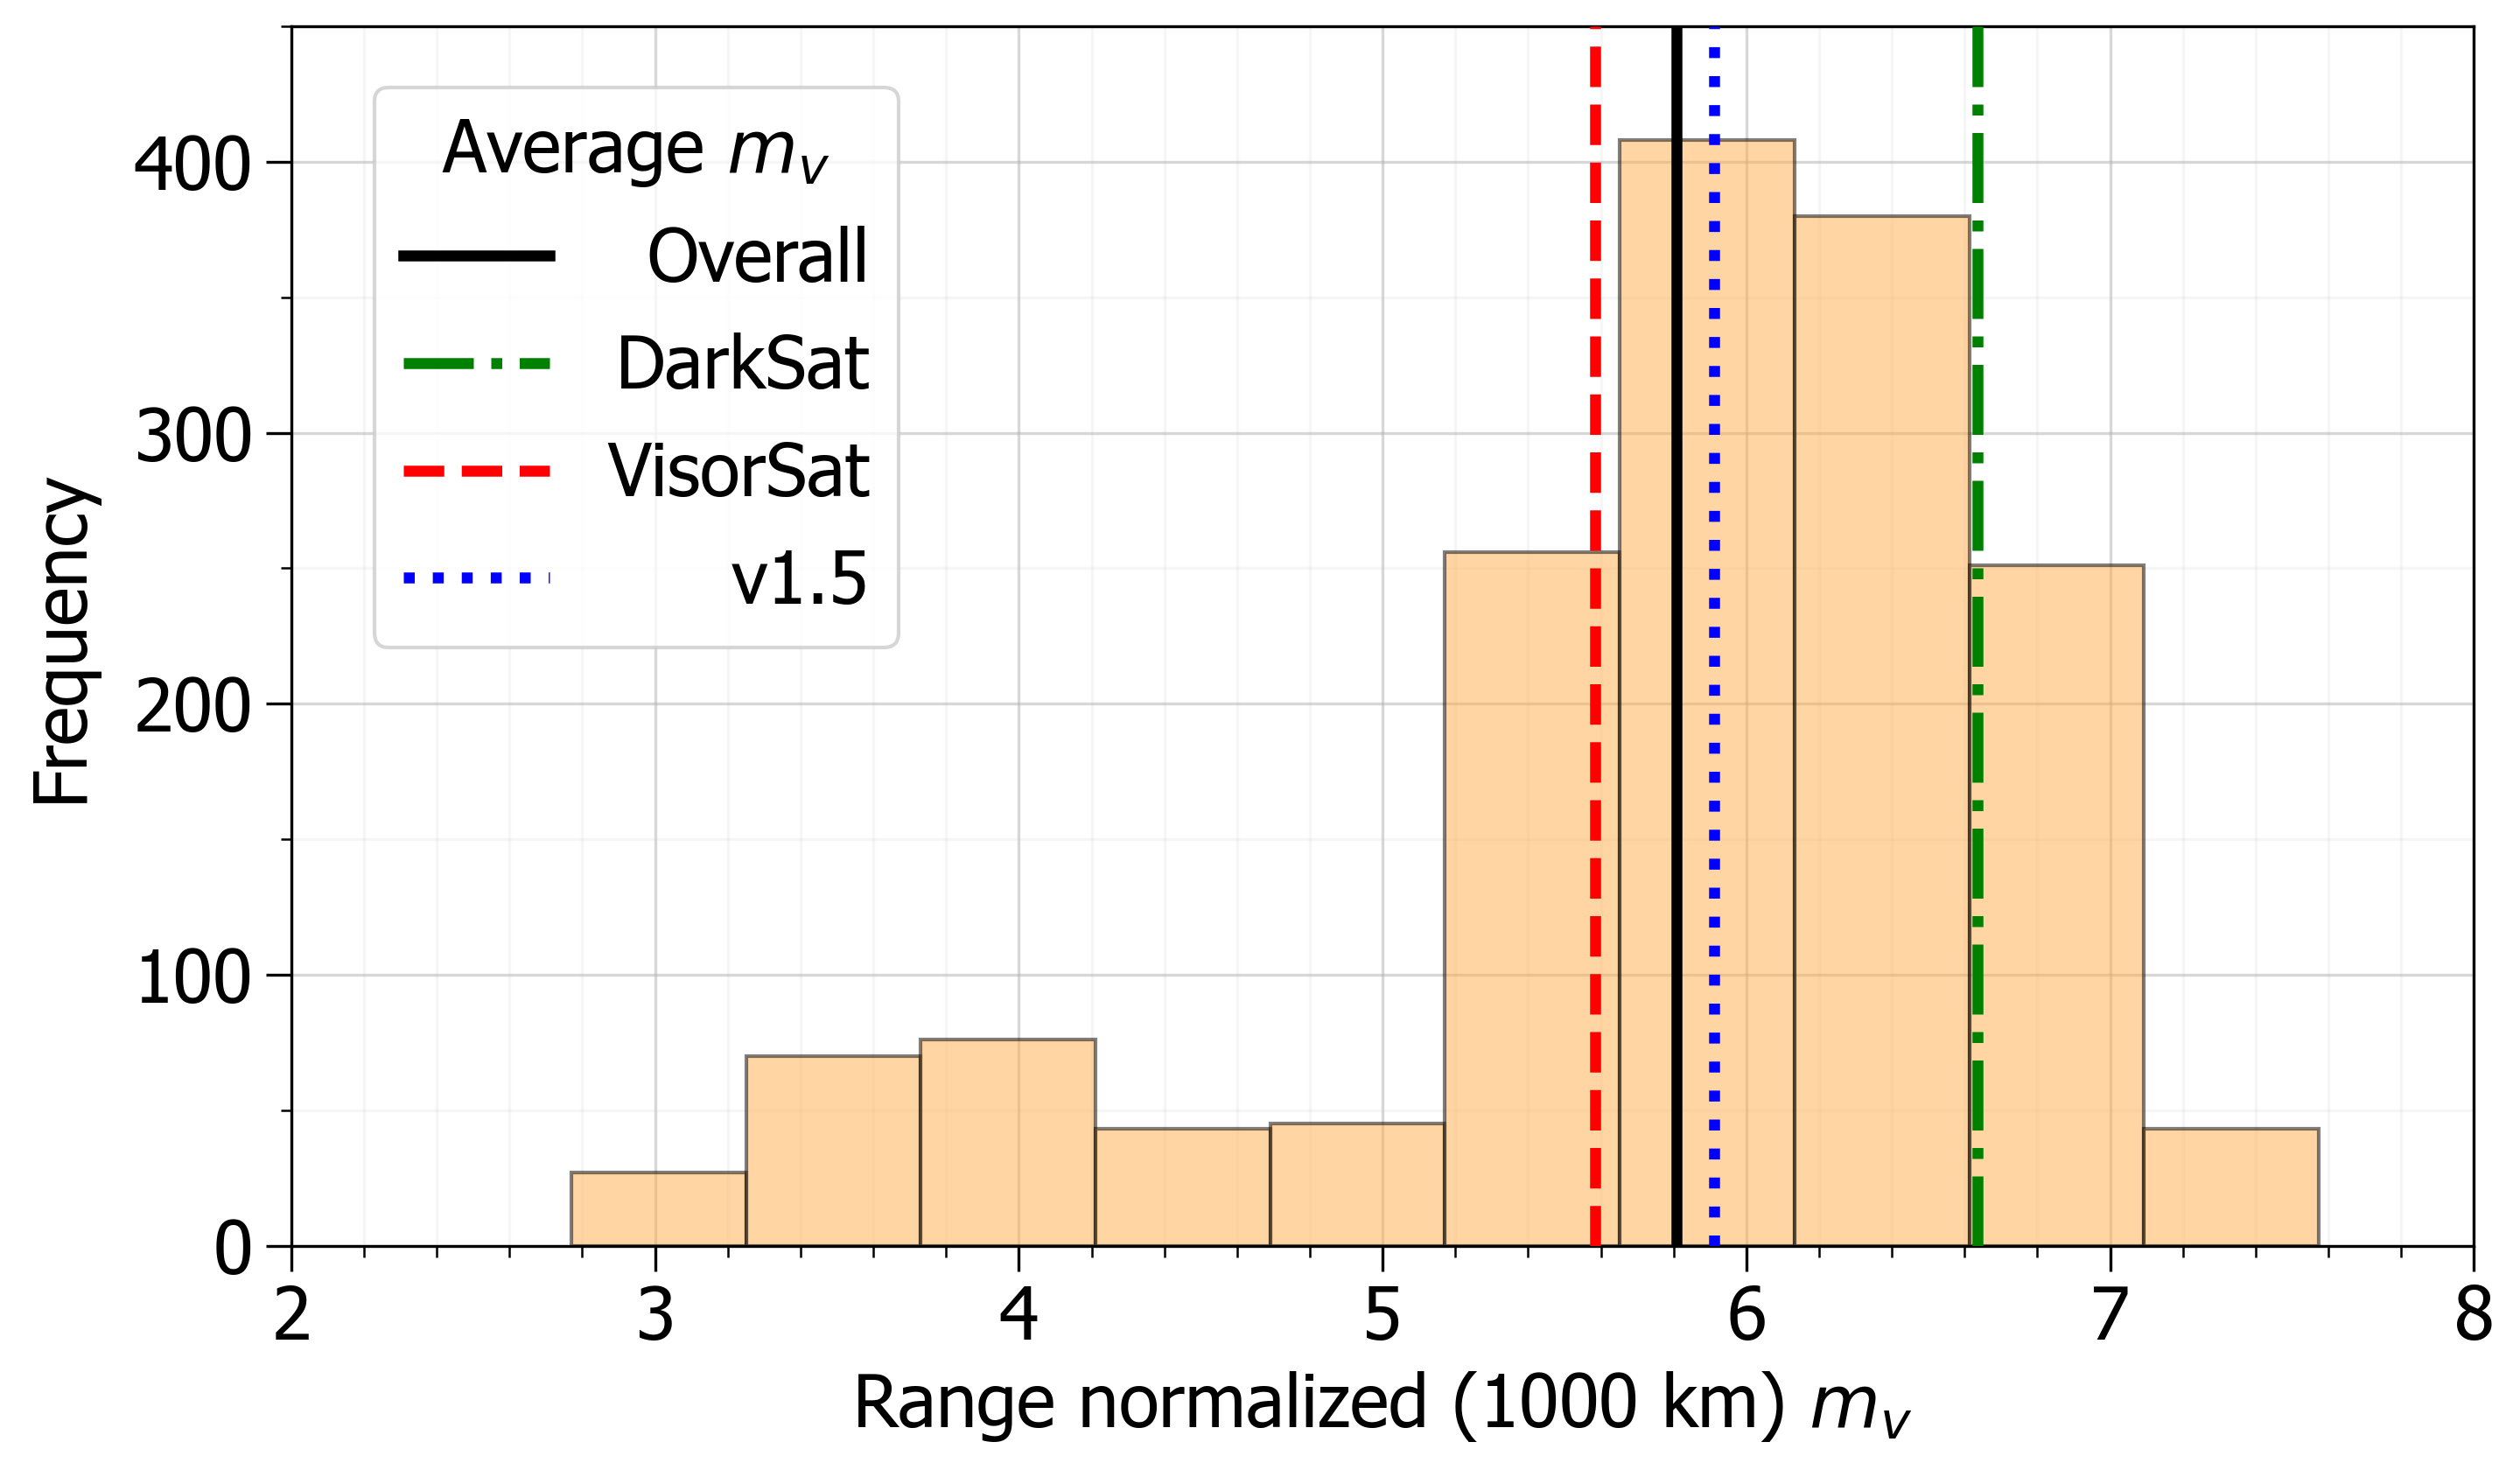

In [4]:
def hist_averages_norm(normtype='1000', savefig=False):

    fig, ax = plt.subplots(1, 1, figsize=[10,6])

    column = f'vmag_norm_{normtype}'
    standard = df[df.type=='standard'][[column]]
    visors   = df[df.type=='visorsat'][[column]]
    darksat  = df[df.type=='darksat'][[column]]

    n_bins = 10
    ax.hist(df[column], n_bins, fc='#ffae49', alpha=0.5, zorder=2, ec='k')
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)

    stand = df[df.type=='standard']
    v15 = stand[stand.version=='1.5'][column]

    ax.axvline(np.mean(df[column]),       c='black', lw=3, zorder=3, ls='-', label='Overall') 
    ax.axvline(np.mean(darksat[column]),  c='green', lw=3, zorder=3, ls='-.', label='DarkSat')
    ax.axvline(np.mean(visors[column]),   c='red', lw=3, zorder=3, ls='--', label='VisorSat')
    # ax.axvline(np.mean(standard[column]), c='blue', lw=3, zorder=3, ls=':', label='OtherSat')
    ax.axvline(np.mean(v15), c='blue', lw=3, zorder=3, ls=':', label='v1.5')
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', length=7, direction='out') 
    ax.tick_params(axis='both', which='minor', length=3, direction='out')   
    ax.set_ylabel('Frequency', labelpad=10, fontsize=20)
    ax.set_xlabel(f'Range normalized ({normtype} km) $m_v$', fontsize=20)
    
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
    ax.set_ylim([0,450])
    ax.set_xlim([2,8])

    leg = ax.legend(title=r'Average $m_v$', fontsize=20, frameon=True, bbox_to_anchor=(0.295,0.98)) #$\overline{m}_v$
    max_shift = max([t.get_window_extent().width for t in leg.get_texts()])
    for t in leg.get_texts():
        t.set_ha('left')
        temp_shift = max_shift - t.get_window_extent().width
        t.set_position((temp_shift, 0))

    
    # for col in ['0.9', '1.0', '1.5']:
    #     data = stand[stand.version==col]['delta']
    #     delta_norm_avg = (np.sqrt(np.sum(data**2))) / len(data)
    #     print(col, np.mean(data), delta_norm_avg)
    
    # for col in ['standard', 'visorsat', 'darksat']:
    #     data = df[df.type==col]['delta']
    #     delta_norm_avg = (np.sqrt(np.sum(data**2))) / len(data)
    #     print(col, delta_norm_avg)
    #     print(np.mean(data))
        
    # data = df['delta']
    # delta_norm_avg = (np.sqrt(np.sum(data**2))) / len(data)
    # print('Overall:', delta_norm_avg)
    # print(round(np.mean(data),2))
    

    plt.tight_layout()
    if savefig:
        plt.savefig('proc_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()

hist_averages_norm(normtype='1000', savefig=False)

In [5]:
def projected_area_data():

    nx = 4008                                                  
    ny = 2672 
    fov_area = (nx*ny)*5
    lstseqs = []
    lsn, lss, lsw, lse, lsc = [], [], [], [], []
    
    files = []
    camid_order = ['LSN', 'LSS', 'LSW', 'LSE', 'LSC']
    for i in camid_order:
        files.extend(glob.glob(f'{datadir}vmags_july/vmags_{i}.p'))

    for f in files:
        p = pd.read_pickle(f)
        lstseqs.extend(p.keys())
    
    jds = []
    for lstseq in np.unique(lstseqs): 
        x = len(jds)
        
        for (f, camid) in zip(files, [lsn, lss, lsw, lse, lsc]):
            vmags = pd.read_pickle(f)
            if lstseq not in vmags.keys():
                camid.append(0)
                continue

            satnums = list(vmags[lstseq])[2:]
            annuli = []
            if len(satnums) != 0:
                for satnum in satnums:
                    annuli.append(vmags[lstseq][satnum]['annulus'])
                z = len(satnums)/3173 #how many starlinks in image relative to total population at time of observation
                camid.append((np.sum(annuli)*z))
            else:
                camid.append(0)
                
            if (len(jds) == 0) | (len(jds) == x):
                jds.append(vmags[lstseq]['JD0'])
    
    perc_40k = []
    perc_500k = []
    for i in range(len(lsc)):
        x = lsc[i] + lse[i] + lsn[i] + lss[i] + lsw[i]
        p40 = ((x*40000)/fov_area) * 100
        p500 = ((x*500000)/fov_area) * 100
        perc_40k.append(p40)
        perc_500k.append(p500)

    timerange = Time(jds, format='jd')

    set_min  = datetime(2022, 10, 24, 0, 15, 0)
    set_max  = datetime(2022, 10, 24, 1, 55, 0)
    rise_min = datetime(2022, 10, 24, 7, 0, 0)
    rise_max = datetime(2022, 10, 24, 9, 0, 0)

    set_time = []
    rise_time = []
    for t in timerange:
        if set_min  < t.datetime < set_max:
            set_time.append(t.datetime)
        if rise_min  < t.datetime < rise_max:
            rise_time.append(t.datetime)
    
    return set_time, rise_time, perc_40k, perc_500k

In [6]:
set_time, rise_time, perc_40k, perc_500k = projected_area_data()

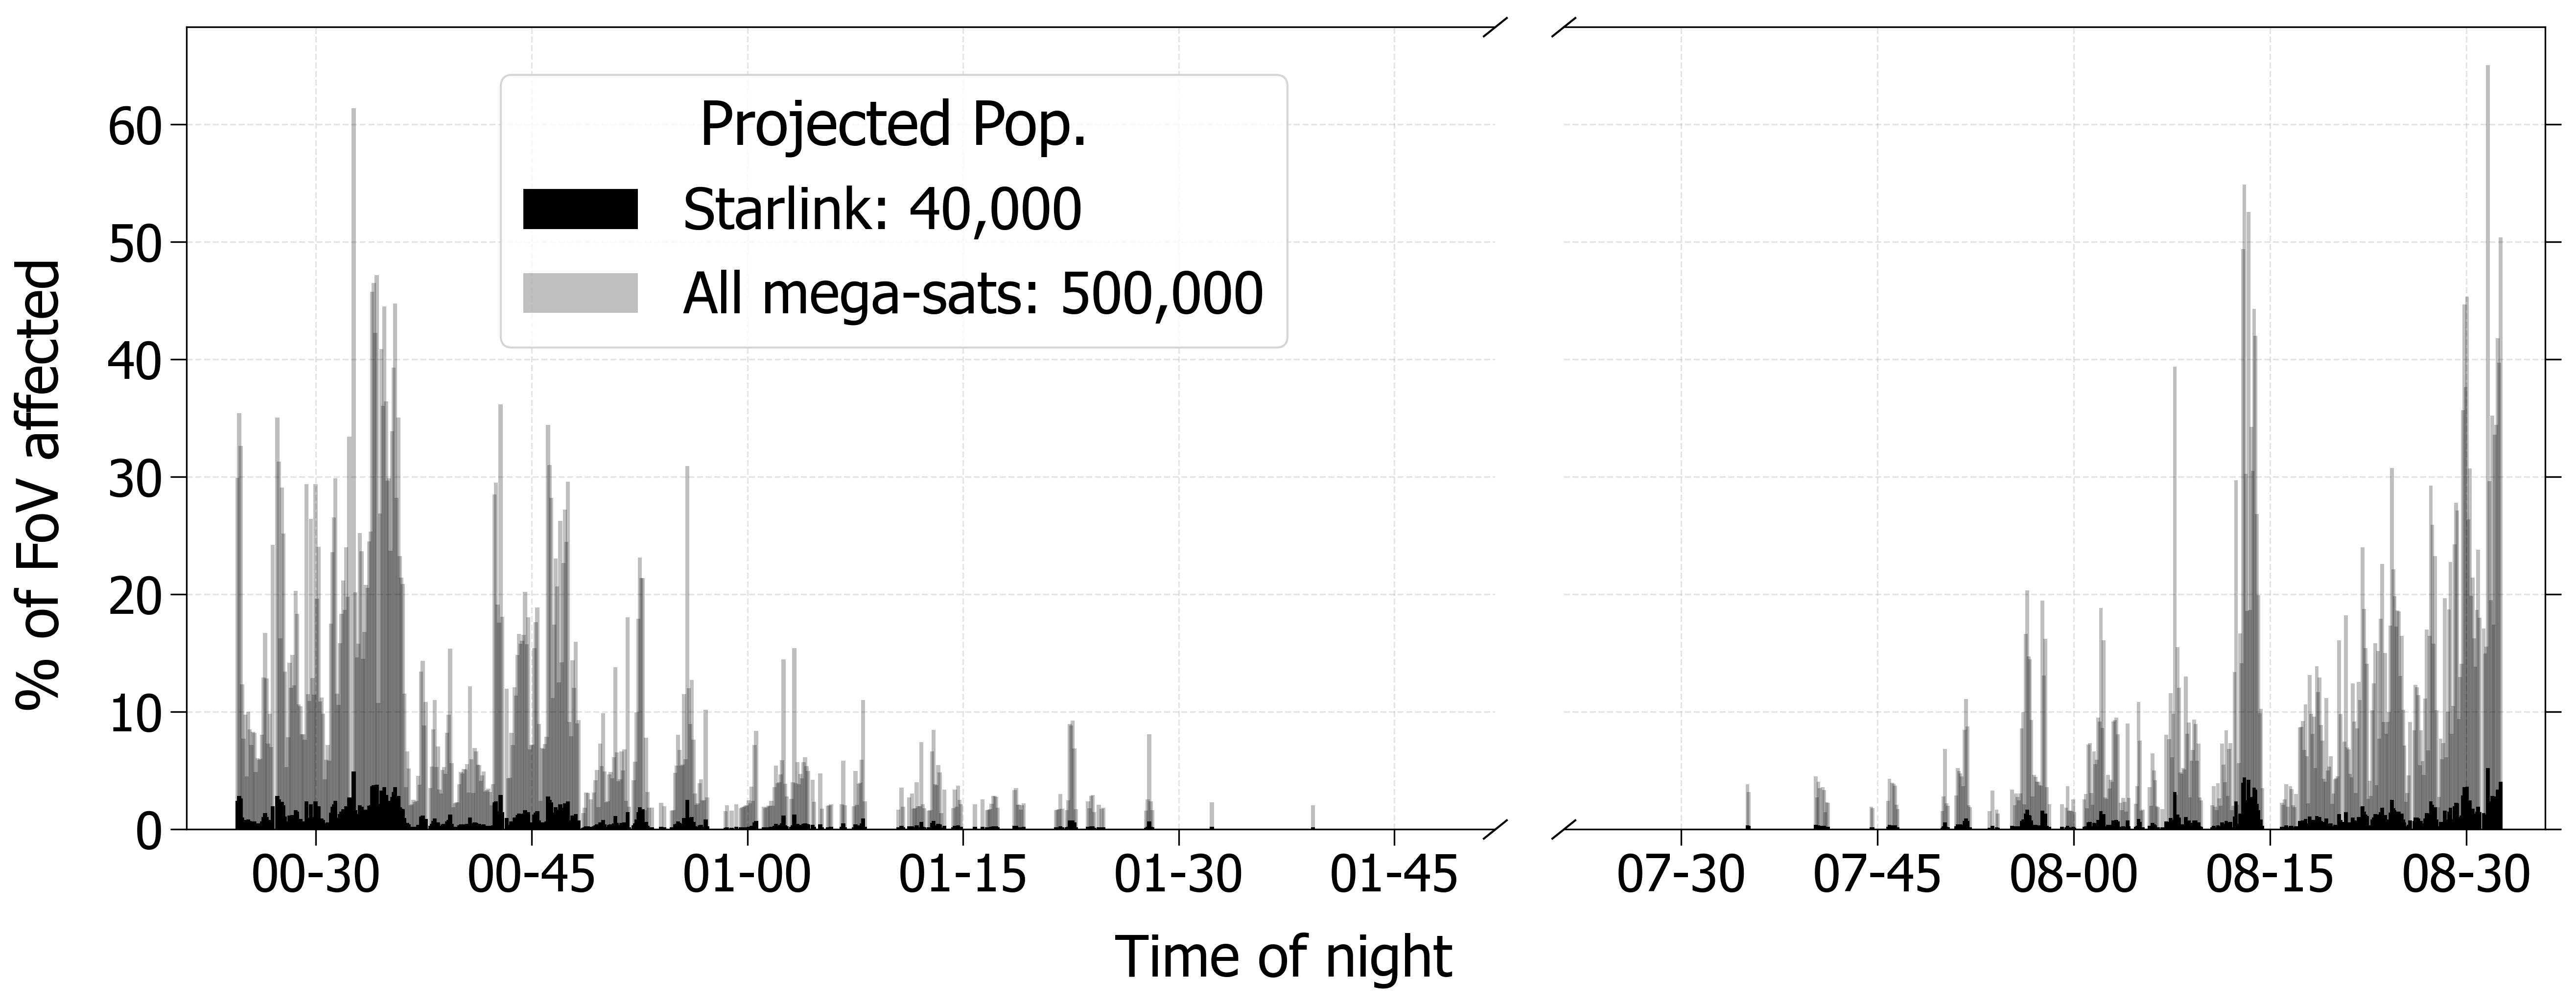

In [17]:
def projected_interference(savefig=False):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[18,7], sharey=True, gridspec_kw={'width_ratios': [2, 1.5]})

    ax1.bar(set_time, perc_500k[0:len(set_time)], width=0.0002, zorder=2, alpha=0.25, color='k', label='All mega-sats: 500,000') 
    ax2.bar(rise_time, perc_500k[-len(rise_time):], width=0.0002, zorder=2, alpha=0.25, color='k') #cornflowerblue

    ax1.bar(set_time, perc_40k[0:len(set_time)], width=0.0002, zorder=3, color='k', label='Starlink: 40,000')
    ax2.bar(rise_time, perc_40k[-len(rise_time):], width=0.0002, zorder=3, color='k')

    ax1.yaxis.tick_left()
    ax1.spines.right.set_visible(False)
    ax2.yaxis.tick_right()
    ax2.tick_params(labelleft=False, labelright=False)
    ax2.spines.left.set_visible(False)
    ax1.grid(color='gray', axis='both', linestyle='--', alpha=0.2, zorder=1)
    ax2.grid(color='gray', axis='both', linestyle='--', alpha=0.2, zorder=1)
    
    handles, labels = ax1.get_legend_handles_labels()
    order = [1,0]
    ax1.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order], 
        loc=[0.24, 0.6], fontsize=28, frameon=True, title='Projected Pop.', title_fontsize=30) #[0.305, 0.63]

    for ax in [ax1,ax2]:
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))
        ax.tick_params(axis='both', which='major', length=8, labelsize=25)

    d = 0.8
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", 
                  color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)

    ax1.set_xlim([datetime(2022, 10, 24, 0, 21, 0), datetime(2022, 10, 24, 1, 52, 0)])
    ax2.set_xlim([datetime(2022, 10, 24, 7, 21, 0), datetime(2022, 10, 24, 8, 36, 0)])

    ax1_xticks = [datetime(2022, 10, 24, 0, 30, 0),
                  datetime(2022, 10, 24, 0, 45, 0),
                  datetime(2022, 10, 24, 1, 0, 0),
                  datetime(2022, 10, 24, 1, 15, 0),
                  datetime(2022, 10, 24, 1, 30, 0),
                  datetime(2022, 10, 24, 1, 45, 0)]
    ax1.set_xticks(ax1_xticks)

    ax2_xticks = [datetime(2022, 10, 24, 7, 30, 0),
                  datetime(2022, 10, 24, 7, 45, 0),
                  datetime(2022, 10, 24, 8, 0, 0),
                  datetime(2022, 10, 24, 8, 15, 0),
                  datetime(2022, 10, 24, 8, 30, 0)]
    ax2.set_xticks(ax2_xticks)

    fig.supylabel('% of FoV affected', fontsize=28)
    fig.supxlabel('Time of night', fontsize=28) 
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.165, left=0.085)
    if savefig:
        plt.savefig(f'proc_interference_BW.png', dpi=300, bbox_inches='tight')
    plt.show()
        
projected_interference(savefig=True)

In [8]:
def trail_example(data, i=1, thresh=False, savefig=False):

    
    data = pf.getdata(data)
    fig, (ax0, ax) = plt.subplots(1, 2, figsize=(18, 6))
    
    if thresh:
        norm = (data - np.min(data)) / (np.max(data) - np.min(data))
        sqrt_image = np.sqrt(norm)
    
        threshold = 0.25#0.185
        image = np.clip(sqrt_image, 0, threshold)
        ax0.imshow(image, cmap='binary_r')
    
    else:
        ax0.imshow(data, cmap='binary_r', vmin=-10, vmax=0)

    ax0.set_xlabel('X (px)', fontsize=20)
    ax0.set_ylabel('Y (px)', labelpad=10, fontsize=20)
        

    column = 'vmag_norm_1000'
    standard = df[df.type=='standard'][[column]]
    visors   = df[df.type=='visorsat'][[column]]
    darksat  = df[df.type=='darksat'][[column]]

    n_bins = 10
    ax.hist(df[column], n_bins, fc='#ffae49', alpha=0.5, zorder=2, ec='k')
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)

    stand = df[df.type=='standard']
    v15 = stand[stand.version=='1.5'][column]
    ax.axvline(np.mean(df[column]),       c='black', lw=3, zorder=3, ls='-', label='Overall') 
    ax.axvline(np.mean(darksat[column]),  c='green', lw=3, zorder=3, ls='-.', label='DarkSat')
    ax.axvline(np.mean(visors[column]),   c='red', lw=3, zorder=3, ls='--', label='VisorSat')
    ax.axvline(np.mean(v15), c='blue', lw=3, zorder=3, ls=':', label='v1.5')
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', length=7, direction='out') 
    ax.tick_params(axis='both', which='minor', length=3, direction='out')   
    ax.set_ylabel('Frequency', labelpad=10, fontsize=20)
    ax.set_xlabel(f'Range normalized (1000 km) $m_v$', fontsize=20)
    
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
    ax.set_ylim([0,450])
    ax.set_xlim([2,8])

    leg = ax.legend(title=r'Average $m_v$', fontsize=20, frameon=True, bbox_to_anchor=(0.32,0.98))
    max_shift = max([t.get_window_extent().width for t in leg.get_texts()])
    for t in leg.get_texts():
        t.set_ha('left')
        temp_shift = max_shift - t.get_window_extent().width
        t.set_position((temp_shift, 0))

    
    plt.tight_layout()
    if savefig:
        plt.savefig('proc_composite.png', dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [9]:
files = sorted(glob.glob(f'{testdir}/outliers/4*'))
trail_example(files[0], thresh=False, i=0, savefig=False)